# Uber Trip Analysis ML

## 1. Importing Libraries 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import glob 
print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Data loading and preprocessing 

In [10]:
files = glob.glob(r'D:\Unified Mentor intern\project 3\Uber-Jan-Feb-FOIL.csv')
all_data = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
print("Actual column names in the dataset:")
print(all_data.columns.tolist())
print("\nFirst 5 rows of the data:")
print(all_data.head())
print("✅ Data loaded.")
print(f"Total trips in the dataset: {len(all_data):,}")

Actual column names in the dataset:
['dispatching_base_number', 'date', 'active_vehicles', 'trips']

First 5 rows of the data:
  dispatching_base_number      date  active_vehicles  trips
0                  B02512  1/1/2015              190   1132
1                  B02765  1/1/2015              225   1765
2                  B02764  1/1/2015             3427  29421
3                  B02682  1/1/2015              945   7679
4                  B02617  1/1/2015             1228   9537
✅ Data loaded.
Total trips in the dataset: 354


## 3. Resample data for hourly analysis

In [22]:
print("Available columns:", all_data.columns.tolist())
print(all_data.head())
datetime_column = 'date'  
all_data[datetime_column] = pd.to_datetime(all_data[datetime_column])
hourly_counts = all_data.resample('h', on=datetime_column).size().reset_index(name='Trip Count')
hourly_counts['Hour'] = hourly_counts[datetime_column].dt.hour
hourly_counts['DayOfWeek'] = hourly_counts[datetime_column].dt.day_name()
hourly_counts['Month'] = hourly_counts[datetime_column].dt.month_name()
print("First 5 rows of the resampled hourly data:")
hourly_counts.head()

Available columns: ['dispatching_base_number', 'date', 'active_vehicles', 'trips']
  dispatching_base_number       date  active_vehicles  trips
0                  B02512 2015-01-01              190   1132
1                  B02765 2015-01-01              225   1765
2                  B02764 2015-01-01             3427  29421
3                  B02682 2015-01-01              945   7679
4                  B02617 2015-01-01             1228   9537
First 5 rows of the resampled hourly data:


,date,Trip Count,Hour,DayOfWeek,Month
0,2015-01-01 00:00:00,6,0,Thursday,January
1,2015-01-01 01:00:00,0,1,Thursday,January
2,2015-01-01 02:00:00,0,2,Thursday,January
3,2015-01-01 03:00:00,0,3,Thursday,January
4,2015-01-01 04:00:00,0,4,Thursday,January


## 4. EDA - Heatmap of Trips by Hour and Day

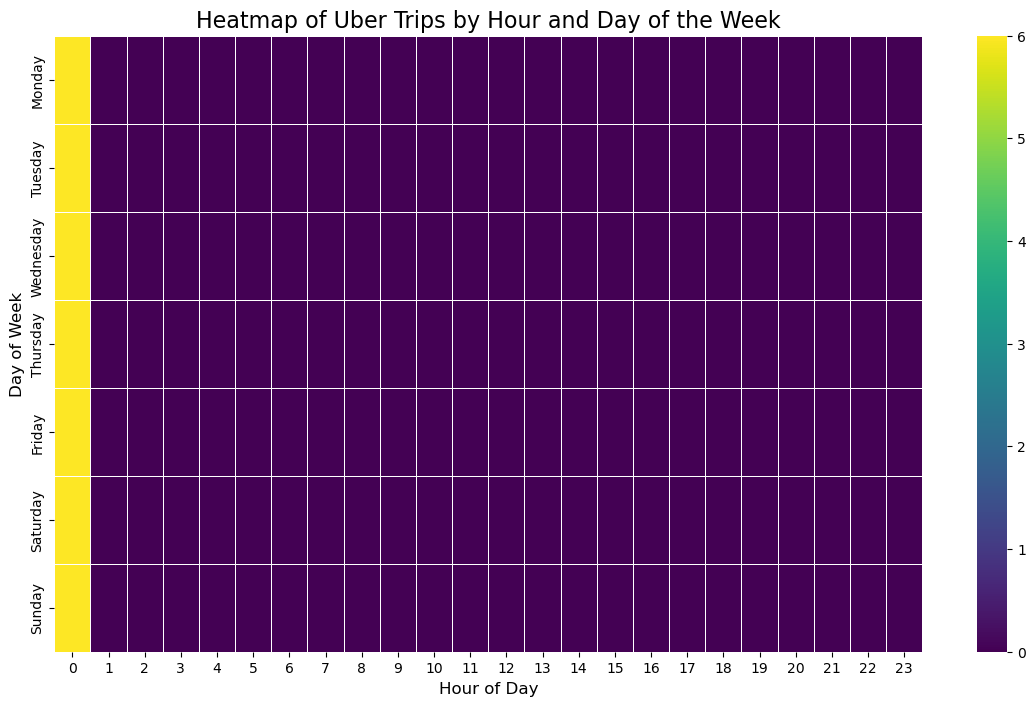

In [24]:
plt.figure(figsize=(14, 8))
day_hour_pivot = hourly_counts.pivot_table(values='Trip Count', index='DayOfWeek', columns='Hour')
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_hour_pivot = day_hour_pivot.reindex(ordered_days)
sns.heatmap(day_hour_pivot, cmap='viridis', linecolor='white', linewidths=0.5)
plt.title('Heatmap of Uber Trips by Hour and Day of the Week', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.show()

## 5. Model Preparation

In [48]:
df_model = hourly_counts.copy()
df_model.set_index('date', inplace=True)
df_model['hour'] = df_model.index.hour
df_model['day'] = df_model.index.day
df_model['day_of_week'] = df_model.index.dayofweek 
df_model['month'] = df_model.index.month
df_model['quarter'] = df_model.index.quarter
df_model['day_of_year'] = df_model.index.dayofyear
X = df_model[['hour', 'day', 'day_of_week', 'month', 'quarter', 'day_of_year']]
y = df_model['Trip Count']
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print("✅ Data prepared for modeling.")
print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")

✅ Data prepared for modeling.
Training set size: 1114 samples
Test set size: 279 samples


## 6. Model Building with LightGBM

In [35]:
print("⏳ Training the LightGBM model...")
lgbm = lgb.LGBMRegressor(
    objective='regression_l1', 
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
print("✅ Model training complete. Predictions made.")

⏳ Training the LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 1114, number of used features: 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

## 7. Model Evaluation

In [37]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("\n--- Model Evaluation ---")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f} trips")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f} trips")
print("------------------------")


--- Model Evaluation ---
R² Score: 1.0000
Mean Absolute Error (MAE): 0.0000 trips
Root Mean Squared Error (RMSE): 0.0000 trips
------------------------


## 8. Visualization of Result

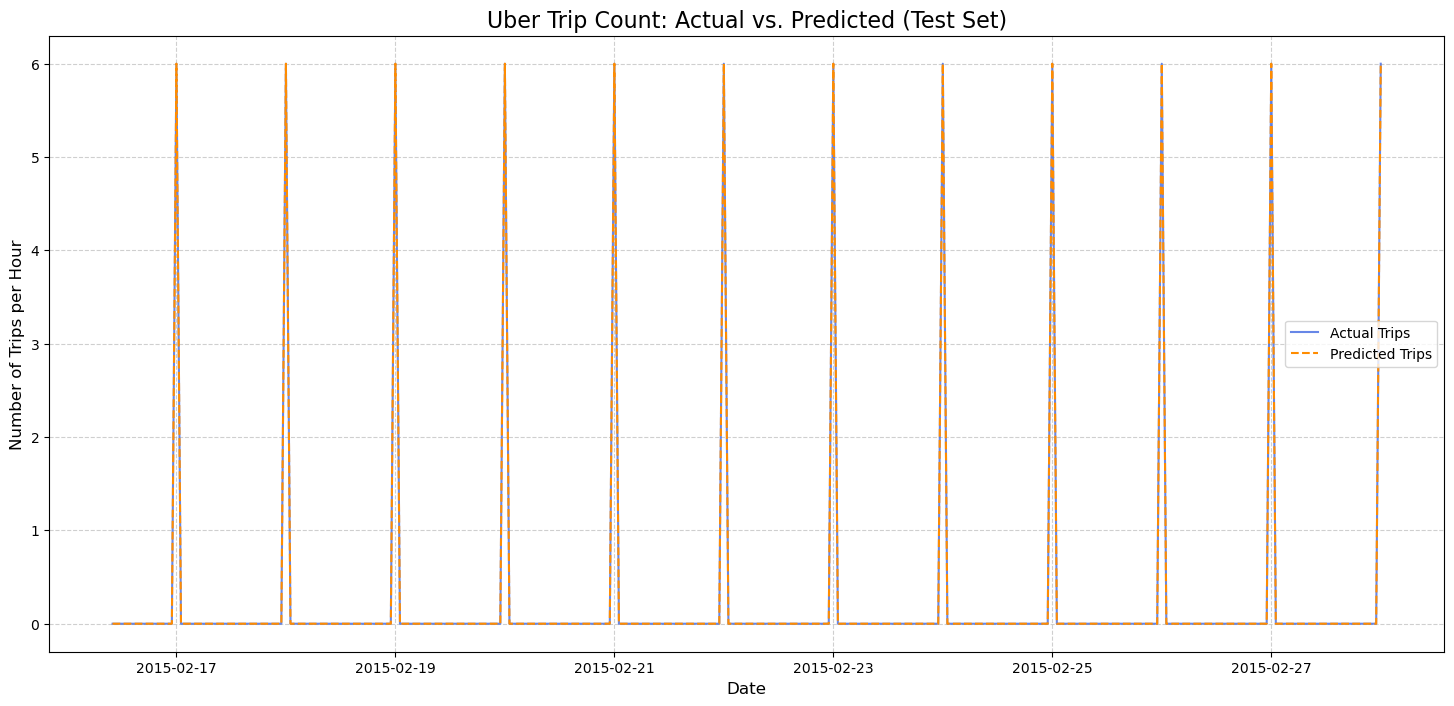

In [39]:
plt.figure(figsize=(18, 8))
plt.plot(y_test.index, y_test, label='Actual Trips', color='royalblue', alpha=0.8)
plt.plot(y_test.index, y_pred, label='Predicted Trips', color='darkorange', linestyle='--')
plt.title('Uber Trip Count: Actual vs. Predicted (Test Set)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Trips per Hour', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 9. Model building with random forest regressor

In [43]:
from sklearn.ensemble import RandomForestRegressor
print("⏳ Training the Random Forest Regressor...")
rf = RandomForestRegressor(
    n_estimators=100,  
    random_state=42,
    n_jobs=-1,         
    max_depth=10,     
    min_samples_leaf=5 
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("✅ Random Forest training complete.")

⏳ Training the Random Forest Regressor...
✅ Random Forest training complete.


## 10. Model evaluation 

In [45]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print("\n--- Random Forest Evaluation ---")
print(f"R² Score: {r2_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f} trips")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f} trips")
print("--------------------------------")


--- Random Forest Evaluation ---
R² Score: 1.0000
Mean Absolute Error (MAE): 0.0000 trips
Root Mean Squared Error (RMSE): 0.0000 trips
--------------------------------


## 11. Visualization of result

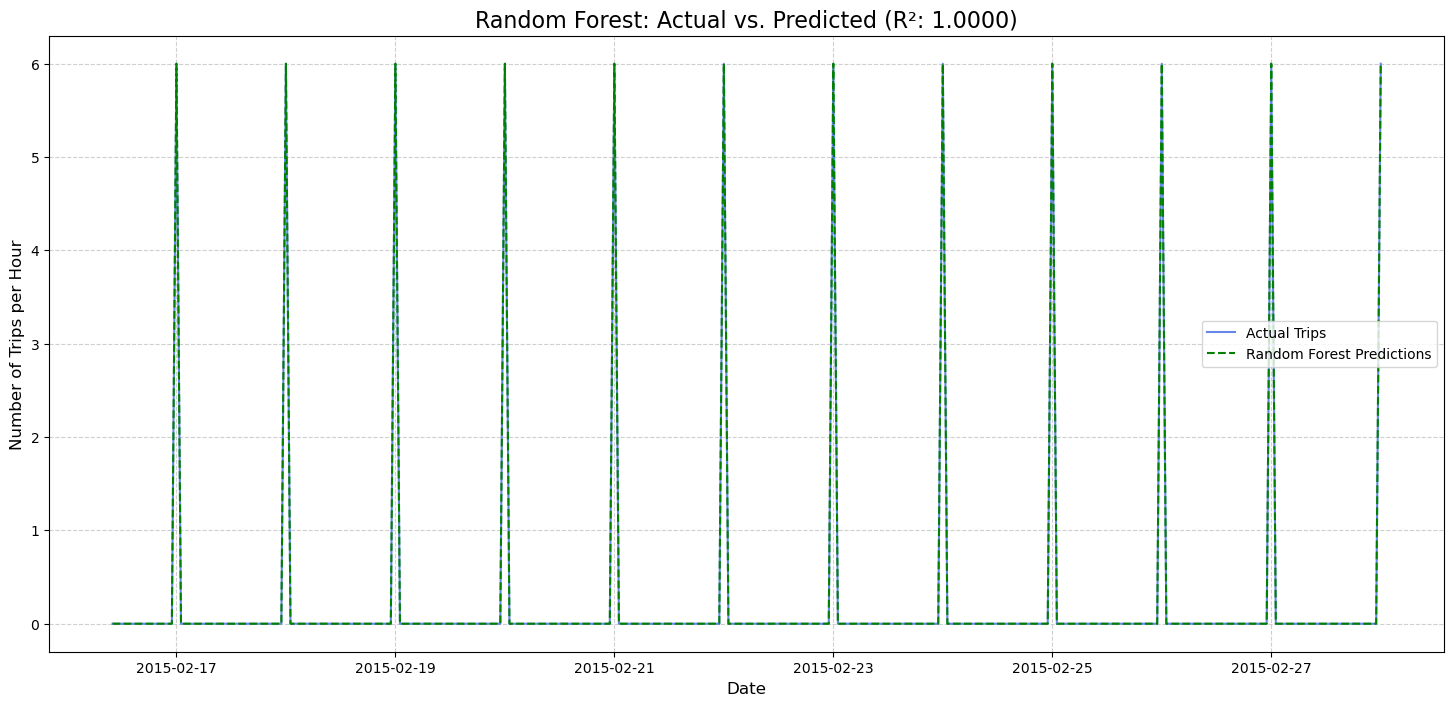

In [47]:
plt.figure(figsize=(18, 8))
plt.plot(y_test.index, y_test, label='Actual Trips', color='royalblue', alpha=0.8)
plt.plot(y_test.index, y_pred_rf, label='Random Forest Predictions', color='green', linestyle='--')
plt.title(f'Random Forest: Actual vs. Predicted (R²: {r2_rf:.4f})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Trips per Hour', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 12. Model building with XGBoost Regressor

In [50]:
import xgboost as xgb
print("⏳ Training the XGBoost Regressor...")
xgbr = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_test)
print("✅ XGBoost training complete.")

⏳ Training the XGBoost Regressor...
✅ XGBoost training complete.


## 13. Model evaluation 

In [52]:
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print("\n--- XGBoost Regressor Evaluation ---")
print(f"R² Score: {r2_xgb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f} trips")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.4f} trips")
print("------------------------------------")


--- XGBoost Regressor Evaluation ---
R² Score: 1.0000
Mean Absolute Error (MAE): 0.0000 trips
Root Mean Squared Error (RMSE): 0.0000 trips
------------------------------------


## 14. Visualization of result

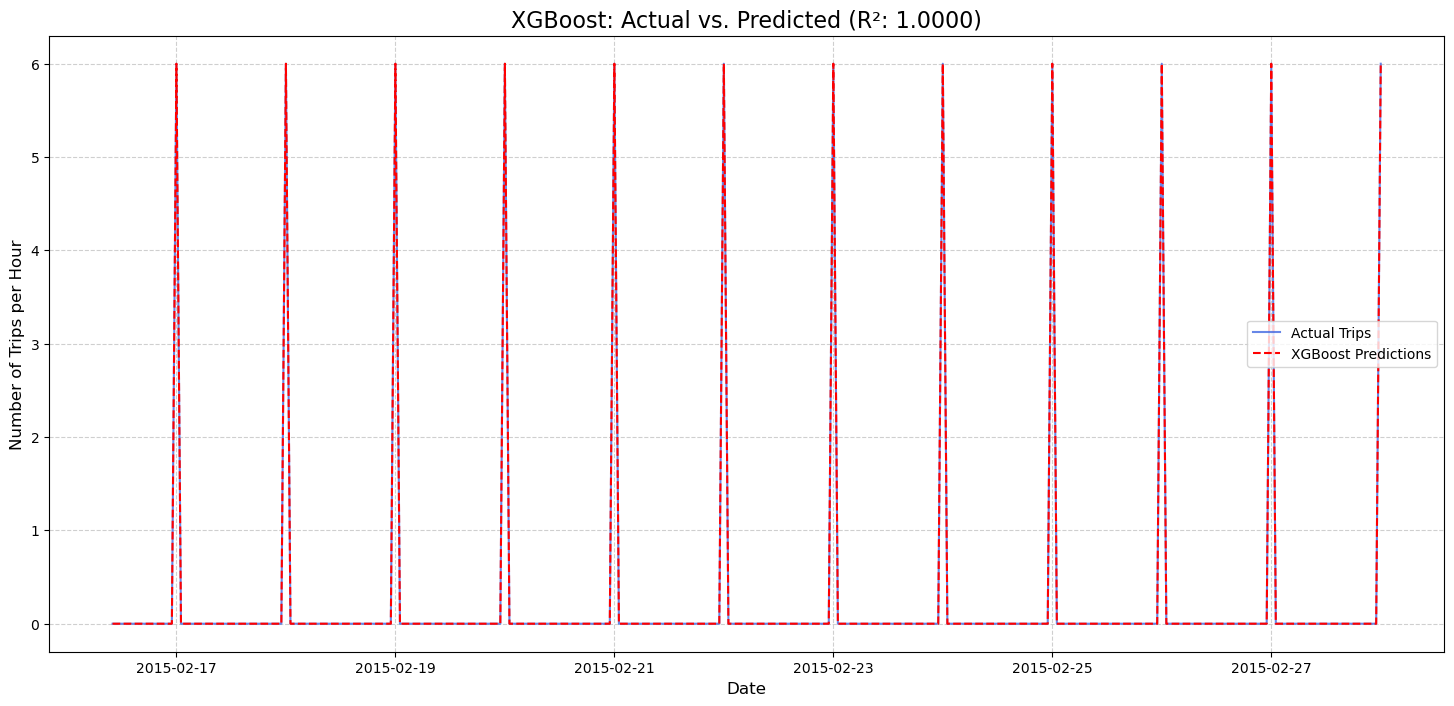

In [54]:
plt.figure(figsize=(18, 8))
plt.plot(y_test.index, y_test, label='Actual Trips', color='royalblue', alpha=0.8)
plt.plot(y_test.index, y_pred_xgb, label='XGBoost Predictions', color='red', linestyle='--')
plt.title(f'XGBoost: Actual vs. Predicted (R²: {r2_xgb:.4f})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Trips per Hour', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 15. Visual Comparison of All Models

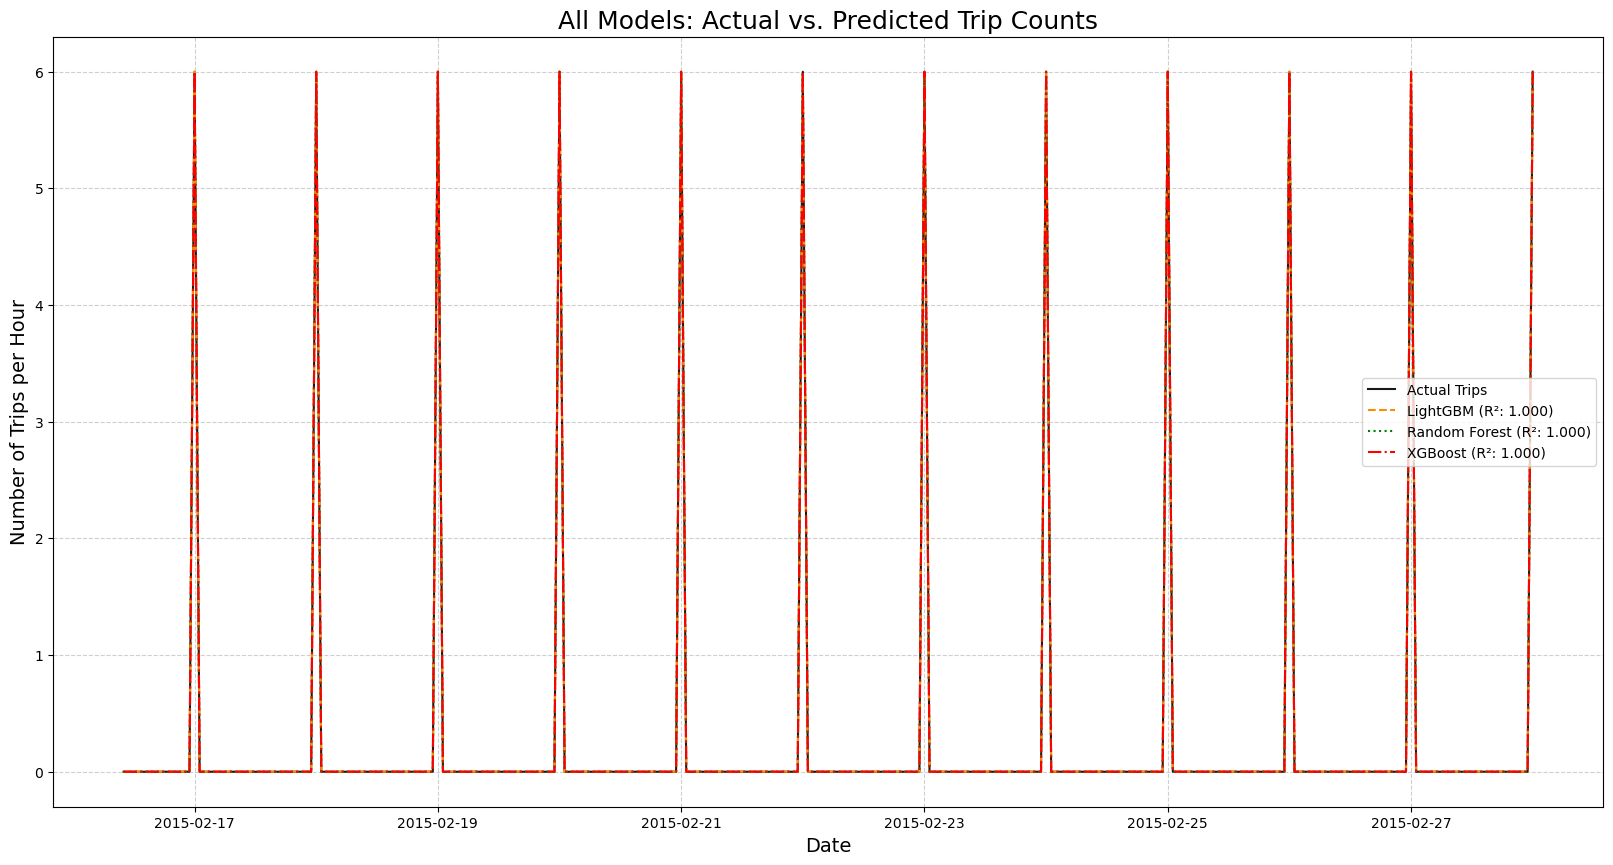

In [56]:
plt.figure(figsize=(20, 10))
plt.plot(y_test.index, y_test, label='Actual Trips', color='black', alpha=0.9)
plt.plot(y_test.index, y_pred, label=f'LightGBM (R²: {r2:.3f})', color='darkorange', linestyle='--')
plt.plot(y_test.index, y_pred_rf, label=f'Random Forest (R²: {r2_rf:.3f})', color='green', linestyle=':')
plt.plot(y_test.index, y_pred_xgb, label=f'XGBoost (R²: {r2_xgb:.3f})', color='red', linestyle='-.')
plt.title('All Models: Actual vs. Predicted Trip Counts', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Trips per Hour', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 16. Final Metrics Comparison

In [58]:
comparison_data = {
    'Model': ['LightGBM', 'Random Forest', 'XGBoost'],
    'R² Score': [r2, r2_rf, r2_xgb],
    'Mean Absolute Error (MAE)': [mae, mae_rf, mae_xgb],
    'Root Mean Squared Error (RMSE)': [rmse, rmse_rf, rmse_xgb]
}
metrics_df = pd.DataFrame(comparison_data).set_index('Model')
metrics_df = metrics_df.sort_values(by='R² Score', ascending=False)
print("--- Model Performance Comparison ---")
metrics_df

--- Model Performance Comparison ---


,R² Score,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
Model,,,
LightGBM,1.0,3.820122e-16,1.841996e-15
Random Forest,1.0,0.000000e+00,0.000000e+00
XGBoost,1.0,1.173623e-05,2.919002e-05
